In [1]:
# general
import sys, os, path
import datetime

# nn related
import torch as th
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
import seaborn as sns

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess as pre
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *

# standard datatype
dtype = th.double

In [2]:
with NoStdStreams():
    # read in rans solution from b_ml
    path = '/home/leonriccius/Desktop/CurvedBackwardFacingStep/ratio_20/Re13700_kOmega_150_ref_x_ml_low_lr'
    rans_time = max([int(entry) for entry in os.listdir(path) if entry.isnumeric()])
    grid_rans = pre.readCellCenters(rans_time, path)
    u_rans = pre.readVectorData(rans_time, 'U', path)
    u_levm = pre.readVectorData('7000', 'U', path)

    # # read in rans solution from b_dns
    path_kepsilon = '/home/leonriccius/Desktop/CurvedBackwardFacingStep/ratio_20/Re13700_kEpsilon_150_ref_x'
    rans_time = max([int(entry) for entry in os.listdir(path_kepsilon) if entry.isnumeric()])
    u_kepsilon = pre.readVectorData(rans_time, 'U', path_kepsilon)

    # read in dns solution
    path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata_fs1_fs2_fs3_reduced/CurvedBackwardFacingStep/13700'
    grid_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))
    u_dns = th.load(os.sep.join([path_dns, 'u_dns-torch.th']))

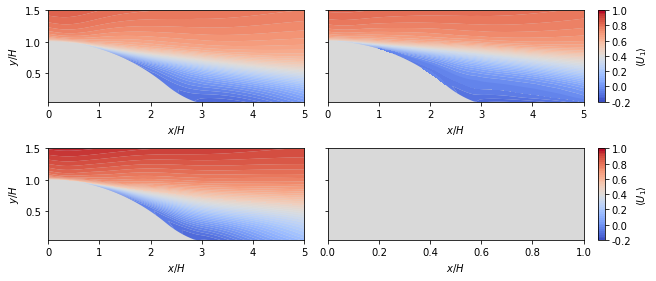

In [4]:
# set refinement level and extent of grid
ref = 15
gamma = 0.995

# define extent of plots
x_min = [-0.0, 0.05]
x_max = [5.0, 1.5]

# compute number of points per coordinate
np_x = int(ref*(x_max[0] - x_min[0]))
np_y = int(ref*(x_max[1] - x_min[1]))

# get grid and shift points on curved boundaries
grid_x, grid_y = np.meshgrid(np.linspace(x_min[0], x_max[0], np_x), np.linspace(x_min[1], x_max[1], np_y))
grid_y_shifted = cbfs_interp(grid_x)*(x_max[1] - grid_y)/x_max[1] + grid_y
grid_y = grid_y_shifted

# interpolate u
grid_u_rans = griddata(grid_rans[:,0:2], u_rans.detach().numpy(), (grid_x, grid_y), method = 'linear')
grid_u_levm = griddata(grid_rans[:,0:2], u_levm.detach().numpy(), (grid_x, grid_y), method = 'linear')
grid_u_dns = griddata(grid_dns[:,0:2], u_dns.detach().numpy(), (grid_x, grid_y), method = 'linear') #, fill_value=0.)

# get min an max of (b_pred, b_test) for colormap
idx = [0]
tmp = np.vstack((grid_u_rans[:,:,0], grid_u_levm[:,:,0], grid_u_dns[:,:,0]))
u_min = np.min(tmp)
u_max = np.max(tmp)
levels = np.linspace(-0.2, 1.0, 50)

# plot layout
nrows = 2
ncols = 2
s = 1.0

# create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*4.5*ncols, s*1.9*nrows), sharex=False, sharey=True,
                       constrained_layout=True)

# set colormap
cmap = matplotlib.cm.get_cmap("coolwarm")

# make contour plots
levm_plot = ax[0,0].contourf(grid_x, grid_y, grid_u_levm[:,:,idx[0]], levels = levels, cmap=cmap)
rans_plot = ax[0,1].contourf(grid_x, grid_y, grid_u_rans[:,:,idx[0]], levels = levels, cmap=cmap)
dns_plot = ax[1,0].contourf(grid_x, grid_y, grid_u_dns[:,:,idx[0]], levels = levels, cmap=cmap)

# remove contour lines
for contour in [levm_plot, rans_plot, dns_plot]:
    for c in contour.collections:
        c.set_edgecolor("face")
        c.set_linewidth(0.00000000000000001)

# make colorbars
for j in range(2):
    cbar = fig.colorbar(rans_plot, ax=ax[j,:].flat, aspect=15*ncols, format='%.1f', pad=0.0, ticks=np.arange(-0.2,1.4,0.2))
    cbar.set_label(r'$\langle U_1 \rangle$')

# set background color (grey)
for axis in ax.flat:
    axis.set_facecolor([0.85, 0.85, 0.85])
    
# set x labels
ax[1,0].set_xlabel(r'$x/H$', fontsize='medium')
ax[1,1].set_xlabel(r'$x/H$', fontsize='medium')
ax[0,0].set_xlabel(r'$x/H$', fontsize='medium')
ax[0,1].set_xlabel(r'$x/H$', fontsize='medium')

# set shared y labels
ax[0,0].set_ylabel(r'$y/H$', fontsize='medium')
ax[1,0].set_ylabel(r'$y/H$', fontsize='medium')

# set titles
x_off = -1.2
y_off = 1.7
# ax[0].text(x_off,y_off, r'LEVM', fontsize='medium', ha='left')
# ax[1].text(x_off,y_off, r'RANS' '\n' r'$b_{ml}$', fontsize='medium', ha='left', va='center')
# ax[2].text(x_off,y_off, r'RANS' '\n' r'$b_{dns}$', fontsize='medium', ha='left', va='center')
# ax[3].text(x_off,y_off, r'DNS', fontsize='medium', ha='left')

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/numerical_results/propagation/curved_backstep'
fig_name =  'Ux_contour.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

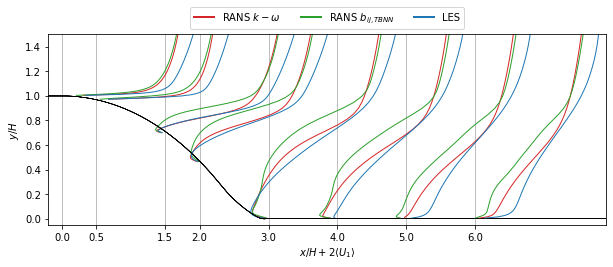

In [5]:
# set path to save figures
# fig_path = '/home/leonriccius/Desktop'

# select x locations to plot
x_data = [0.0, 0.5, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0]
tol = 4e-2
scale_x = 2.0
scale_fig = 1.2

x_bottom = np.linspace(-1, 10, 400)
y_bottom = cbfs_interp(x_bottom)

# reshape arrays
nx, ny = 300, 150
grid_reshaped = grid_rans.reshape(ny, nx, 3)
u_levm_reshaped = u_levm.reshape(ny, nx, 3)
u_rans_reshaped = u_rans.reshape(ny, nx, 3)
u_dns_reshaped = u_dns.reshape(ny, nx, 3)

# # # seaborn colors scheme 1
colors = [sns.color_palette()[3],
         sns.color_palette()[2],
         sns.color_palette()[4],
         sns.color_palette()[0]]

# get grid
nx, ny = 300, 150
grid_reshaped = grid_rans.reshape(ny, nx, 3)

# linewidth
linewidth = 1.0

# select components
components = [0]

# set number of columns to plot
ncols = 1
nrows = len(components)

# create figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(scale_fig*7*ncols, scale_fig*3.0*nrows),
                        sharex=True, sharey=True, constrained_layout=True)

# set ticks to x-locations
plt.xticks(x_data)

for i, cmp in enumerate(components):
    for j, val in enumerate(x_data):
        # find x location in grid
        x_loc = np.argmin(np.absolute(grid_reshaped[0,:,0] - val))
        x_val = grid_reshaped[0, x_loc, 0]

        # create mask and select points in the slice
        grid_slice = grid_reshaped[0:50, x_loc, 1]
        u_dns_slice = u_dns_reshaped[0:50, x_loc, cmp]
        u_levm_slice = u_levm_reshaped[0:50, x_loc, cmp]
        u_rans_slice = u_rans_reshaped[0:50, x_loc, cmp]

        # plot all bs for current slice
        axs.plot(scale_x*u_levm_slice + val, grid_slice, color=colors[0], linewidth=linewidth)
        axs.plot(scale_x*u_rans_slice + val, grid_slice, color=colors[1], linewidth=linewidth)
        axs.plot(scale_x*u_dns_slice + val, grid_slice, color=colors[3], linewidth=linewidth)
        axs.set_ylabel(r'$y/H$')
        
        # plot bottom boundary
        axs.plot(x_bottom, y_bottom, linewidth=0.5, color='black')
    
    # plot grid lines
    axs.grid(axis='x')

# plot legend    
leg = axs.legend([r'RANS $k-\omega$', r'RANS $b_{ij,TBNN}$', r'LES'], bbox_to_anchor=(0.5, 1.00),
                 loc='lower center', ncol=4)

# set axis limits
axs.set_ylim([-0.05, 1.5])
axs.set_xlim([-0.2, 7.9])

# increase linewidth of legend
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

# plot xlabel
axs.set_xlabel(r'$x/H + 2\langle U_1 \rangle$')

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/numerical_results/propagation/curved_backstep/'
fig_name =  'Ux_section.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

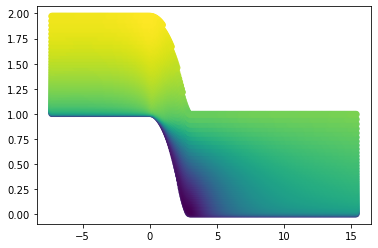

In [9]:
# reshape grid
nx, ny = 300, 150
grid_reshaped = grid_rans.reshape(ny, nx, 3)
u_rans_reshaped = u_rans.reshape(ny, nx, 3)
u_dns_reshaped = u_dns.reshape(ny, nx, 3)

# select section
x_lim = [-1., 6.]
delta_y = 1.0

# define boundary layer upper limit
y_top_bound = grid_rans.reshape(ny, nx, 3)[0,:,1] + delta_y

# mask points in boundary layer and select corresponding data
mask = (grid_reshaped[:,:,1] < y_top_bound.unsqueeze(0))
grid_sel = grid_reshaped[mask]
u_rans_sel = u_rans.reshape(ny, nx, -1)[mask]
u_levm_sel = u_levm.reshape(ny, nx, -1)[mask]
u_kepsilon_sel = u_kepsilon.reshape(ny, nx, -1)[mask]
u_dns_sel = u_dns.reshape(ny, nx, -1)[mask]

# plot points in boundary layer
fig, ax = plt.subplots()
ax.scatter(grid_sel[:,0], grid_sel[:,1], c=u_dns_sel[:,0])

### RMSE for Velocities

In [13]:
print('kepsilon   U_i: {:2f},   U_1: {:2f},   U_2: {:2f}'.format(th.sqrt(th.nn.MSELoss()(u_dns_sel[:,0:2], u_kepsilon_sel[:,0:2])),
                                                                 th.sqrt(th.nn.MSELoss()(u_dns_sel[:,0], u_kepsilon_sel[:,0])),
                                                                 th.sqrt(th.nn.MSELoss()(u_dns_sel[:,1], u_kepsilon_sel[:,1]))))
print('komega     U_i: {:2f},   U_1: {:2f},   U_2: {:2f}'.format(th.sqrt(th.nn.MSELoss()(u_dns_sel[:,0:2], u_levm_sel[:,0:2])),
                                                                 th.sqrt(th.nn.MSELoss()(u_dns_sel[:,0], u_levm_sel[:,0])),
                                                                 th.sqrt(th.nn.MSELoss()(u_dns_sel[:,1], u_levm_sel[:,1]))))
print('TBNN       U_i: {:2f},   U_1: {:2f},   U_2: {:2f}'.format(th.sqrt(th.nn.MSELoss()(u_dns_sel[:,0:2], u_rans_sel[:,0:2])),
                                                                 th.sqrt(th.nn.MSELoss()(u_dns_sel[:,0], u_rans_sel[:,0])),
                                                                 th.sqrt(th.nn.MSELoss()(u_dns_sel[:,1], u_rans_sel[:,1]))))

kepsilon   U_i: 0.088288,   U_1: 0.124590,   U_2: 0.008176
komega     U_i: 0.060905,   U_1: 0.085828,   U_2: 0.007239
TBNN       U_i: 0.086801,   U_1: 0.121564,   U_2: 0.017055
